In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report


pd.set_option('display.max_columns', None)

data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/iseng/DataDNA/September2025/cleaned.xlsx')

onehot_features = ['person_home_ownership', 'loan_intent', 'marital_status',
                   'country', 'state', 'city', 'employment_type']

ordinal_features = ['loan_grade', 'education_level']

label_features = ['cb_person_default_on_file', 'gender']


target = 'loan_status'

X = data.drop(columns=[target, 'city_latitude', 'city_longitude', 'cluster', 'client_ID'])
y = data[target]


X_onehot = pd.get_dummies(X[onehot_features], drop_first=False)

loan_grade_order = ['A','B','C','D','E','F','G']

education_order = ['High School','Bachelor','Master','PhD']

ord_enc = OrdinalEncoder(categories=[loan_grade_order, education_order])
X_ordinal = pd.DataFrame(ord_enc.fit_transform(X[ordinal_features]),
                         columns=ordinal_features, index=X.index)

X_label = pd.DataFrame(index=X.index)
for col in label_features:
    le = LabelEncoder()
    X_label[col] = le.fit_transform(X[col])


numerical_features = X.drop(columns=onehot_features + ordinal_features + label_features).copy()


X_processed = pd.concat([numerical_features, X_onehot, X_ordinal, X_label], axis=1)

print(X_processed.head())
print(f"Shape final X: {X_processed.shape}")
print(f"Target shape: {y.shape}")

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          21           9600                5.0       1000          11.14   
1          25           9600                1.0       5500          12.87   
2          23          65500                4.0      35000          15.23   
3          24          54400                8.0      35000          14.27   
4          21           9900                2.0       2500           7.14   

   cb_person_cred_hist_length  loan_term_months  loan_to_income_ratio  \
0                           2                36              0.104167   
1                           3                36              0.572917   
2                           2                12              0.534351   
3                           4                36              0.643382   
4                           2                36              0.252525   

     other_debt  debt_to_income_ratio  open_accounts  \
0   1607.802794              0.271646     

In [ ]:
X_processed.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_term_months,loan_to_income_ratio,other_debt,debt_to_income_ratio,open_accounts,credit_utilization_ratio,past_delinquencies,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,country_Canada,country_UK,country_USA,state_BC,state_California,state_England,state_New York,state_Ontario,state_Quebec,state_Scotland,state_Texas,state_Wales,city_Buffalo,city_Cardiff,city_Dallas,city_Edinburgh,city_Glasgow,city_Houston,city_London,city_Los Angeles,city_Manchester,city_Montreal,city_New York City,city_Ottawa,city_Quebec City,city_San Francisco,city_Swansea,city_Toronto,city_Vancouver,city_Victoria,employment_type_Full-time,employment_type_Part-time,employment_type_Self-employed,employment_type_Unemployed,loan_grade,education_level,cb_person_default_on_file,gender
0,21,9600,5.0,1000,11.14,2,36,0.104167,1607.802794,0.271646,10,0.585436,3,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,1.0,2.0,0,0
1,25,9600,1.0,5500,12.87,3,36,0.572917,2760.505633,0.860469,14,0.750732,0,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,2.0,2.0,0,0
2,23,65500,4.0,35000,15.23,2,12,0.534351,7155.286150,0.643592,15,0.379333,0,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,2.0,1.0,0,1
3,24,54400,8.0,35000,14.27,4,36,0.643382,15626.153439,0.930628,4,0.228103,0,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2.0,1.0,1,0
4,21,9900,2.0,2500,7.14,2,36,0.252525,2211.741134,0.475933,10,0.827034,0,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,0.0,0.0,0,1


In [ ]:


clusters = data['cluster'].unique()
probabilities = pd.Series(index=data.index, dtype=float)

for c in clusters:
    print(f"\n===== Cluster {c} =====")

    cluster_idx = data['cluster'] == c
    X_cluster = X_processed[cluster_idx]
    y_cluster = y[cluster_idx]


    X_train, X_test, y_train, y_test = train_test_split(
        X_cluster, y_cluster, test_size=0.2, random_state=42, stratify=y_cluster
    )

    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    prob_default = model.predict_proba(X_cluster)[:, 1]
    probabilities.loc[cluster_idx] = prob_default

    print(classification_report(y_test, y_pred, digits=3))


data['prob_default'] = probabilities

print(data[['cluster','loan_status','prob_default']].head(20))



===== Cluster 1 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:39:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.946     0.999     0.972      3695
           1      0.986     0.621     0.762       556

    accuracy                          0.949      4251
   macro avg      0.966     0.810     0.867      4251
weighted avg      0.951     0.949     0.944      4251


===== Cluster 0 =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:39:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0      0.880     0.983     0.929      1400
           1      0.966     0.784     0.865       865

    accuracy                          0.907      2265
   macro avg      0.923     0.883     0.897      2265
weighted avg      0.913     0.907     0.905      2265

    cluster  loan_status  prob_default
0         1            0      0.097910
1         0            1      0.992704
2         0            1      0.989693
3         0            1      0.995900
4         1            1      0.994764
5         1            1      0.988997
6         1            1      0.989918
7         1            1      0.990362
8         0            1      0.873473
9         1            1      0.989698
10        1            1      0.998335
11        1            1      0.993379
12        0            1      0.911938
13        1            0      0.048705
14        1            0      0.018502
15        1            0      0.010403
16        

In [ ]:
data.head()

,client_ID,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,gender,marital_status,education_level,country,state,city,city_latitude,city_longitude,employment_type,loan_term_months,loan_to_income_ratio,other_debt,debt_to_income_ratio,open_accounts,credit_utilization_ratio,past_delinquencies,cluster,prob_default
0,CUST_00002,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,N,2,Female,Divorced,Master,Canada,Ontario,Toronto,43.6532,-79.3832,Full-time,36,0.104167,1607.802794,0.271646,10,0.585436,3,1,0.097910
1,CUST_00003,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,N,3,Female,Married,Master,UK,Wales,Swansea,51.6214,-3.9436,Full-time,36,0.572917,2760.505633,0.860469,14,0.750732,0,0,0.992704
2,CUST_00004,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,N,2,Male,Married,Bachelor,Canada,BC,Vancouver,49.2827,-123.1207,Part-time,12,0.534351,7155.286150,0.643592,15,0.379333,0,0,0.989693
3,CUST_00005,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,Y,4,Female,Single,Bachelor,USA,New York,Buffalo,42.8864,-78.8784,Part-time,36,0.643382,15626.153439,0.930628,4,0.228103,0,0,0.995900
4,CUST_00006,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,N,2,Male,Single,High School,USA,California,San Francisco,37.7749,-122.4194,Full-time,36,0.252525,2211.741134,0.475933,10,0.827034,0,1,0.994764


In [ ]:

mask = (data['prob_default'] >= 0.2) & (data['prob_default'] <= 0.6)
subset = data[mask]

print(f"num customer with prob_default 20%-60%: {subset.shape[0]}")
print(subset[['client_ID','cluster','loan_status','prob_default']].head(20))


num customer with prob_default 20%-60%: 2333
      client_ID  cluster  loan_status  prob_default
42   CUST_00044        0            0      0.564116
83   CUST_00086        1            1      0.270553
98   CUST_00101        1            0      0.222973
102  CUST_00105        1            1      0.456346
121  CUST_00124        0            0      0.301830
157  CUST_00160        0            1      0.514933
193  CUST_00197        0            1      0.432344
247  CUST_00252        0            0      0.222337
345  CUST_00350        0            0      0.362078
366  CUST_00371        1            0      0.275134
476  CUST_00481        0            0      0.296079
511  CUST_00516        1            1      0.240689
522  CUST_00527        1            1      0.325503
558  CUST_00563        0            1      0.397921
620  CUST_00626        1            0      0.216761
635  CUST_00641        1            0      0.429122
659  CUST_00665        0            0      0.211506
691  CUST_00697    

## THOMPSON SAMPLING

In [ ]:
# We apply the medium-risk filter (prob_default 20–60%) because Thompson Sampling is most effective when there is enough variability in the probability of success.
#Very low-risk customers almost always pay, and very high-risk customers almost always default, so strategies have little impact.
#Focusing on medium-risk customers allows the algorithm to better differentiate and identify the most effective strategies.”

In [ ]:
#### DISCLAIMER ####
#This result is heavily influenced by the initial prior assumptions on strategy effects.
#It reflects an exploratory scenario based on domain knowledge rather than actual customer data. Probabilities of default from ML are not fully incorporated, so results may differ from realistic outcomes.

In [ ]:

mask = (data['prob_default'] >= 0.2) & (data['prob_default'] <= 0.6)
data_ts = data[mask].copy()

arms_dict = {
    0: ['Interest Discount', 'Loan Grade Upgrade', 'Baseline'],
    1: ['Longer Tenor', 'Financial Education', 'Small Interest Discount', 'Baseline']
}


effects_prior = {
    0: {
        'Interest Discount': {'alpha': 2, 'beta': 5},   # mean ~0.29
        'Loan Grade Upgrade': {'alpha': 1.5, 'beta': 4}, # mean ~0.27
        'Baseline': {'alpha': 1, 'beta': 1}             # mean 0.5
    },
    1: {
        'Longer Tenor': {'alpha': 3, 'beta': 7},        # mean ~0.3
        'Financial Education': {'alpha': 1.5, 'beta': 4},
        'Small Interest Discount': {'alpha': 1, 'beta': 3},
        'Baseline': {'alpha': 1, 'beta': 1}
    }
}


beta_params = {}
for cluster, arms in arms_dict.items():
    beta_params[cluster] = {arm: {'alpha': 1, 'beta': 1} for arm in arms}


n_iterations = 3000
best_arm_per_cluster = {}

for cluster in arms_dict.keys():
    arms = arms_dict[cluster]
    prob_cluster = data_ts.loc[data_ts['cluster'] == cluster, 'prob_default'].values
    beta_cluster = beta_params[cluster]

    for i in range(n_iterations):
        theta_samples = {arm: np.random.beta(beta_cluster[arm]['alpha'], beta_cluster[arm]['beta']) for arm in arms}
        chosen_arm = max(theta_samples, key=theta_samples.get)


        sampled_effect = np.random.beta(
            effects_prior[cluster][chosen_arm]['alpha'],
            effects_prior[cluster][chosen_arm]['beta']
        )

        for prob in prob_cluster:
            reward = np.random.binomial(1, max(min(1 - prob + sampled_effect, 1), 0))
            beta_cluster[chosen_arm]['alpha'] += reward
            beta_cluster[chosen_arm]['beta'] += 1 - reward


        effects_prior[cluster][chosen_arm]['alpha'] += reward
        effects_prior[cluster][chosen_arm]['beta'] += 1 - reward


    posterior_means = {arm: beta_cluster[arm]['alpha'] / (beta_cluster[arm]['alpha'] + beta_cluster[arm]['beta']) for arm in arms}
    best_arm_per_cluster[cluster] = max(posterior_means, key=posterior_means.get)

print("Rekomendasi strategi terbaik per cluster (Bayesian prior TS):")
print(best_arm_per_cluster)


Rekomendasi strategi terbaik per cluster (Bayesian prior TS):
{0: 'Loan Grade Upgrade', 1: 'Financial Education'}


simulating the chosen thompson sampling strategy to see if its effective

In [ ]:
# This code calculates the estimated probability of default for each customer after applying the best prescriptive strategy per cluster.
# It uses the best arm per cluster from Thompson Sampling and the posterior mean effect of that arm.
# For each customer, the effect of the strategy is subtracted from their predicted default probability (from the ML model), bounded between 0 and 1.
# The resulting prob_default_after_strategy column represents the deterministic estimated default probability after intervention.
# Aggregation per cluster provides a summary of average reduction in default risk, useful for reporting and decision-making.

In [ ]:
data_sim = data_ts.copy()

best_arms = best_arm_per_cluster


effect_means = {}
for cluster, arms in effects_prior.items():
    effect_means[cluster] = {arm: effects_prior[cluster][arm]['alpha'] /
                                     (effects_prior[cluster][arm]['alpha'] + effects_prior[cluster][arm]['beta'])
                              for arm in arms}


def apply_strategy(row):
    cluster = row['cluster']
    arm = best_arms[cluster]
    effect = effect_means[cluster][arm]
    new_prob = max(min(row['prob_default'] - effect, 1), 0)
    return new_prob

data_sim['prob_default_after_strategy'] = data_sim.apply(apply_strategy, axis=1)



In [ ]:
impact_summary = data_sim.groupby('cluster')[['prob_default', 'prob_default_after_strategy']].mean().reset_index()
impact_summary.rename(columns={
    'prob_default': 'avg_prob_default_before_strategy',
    'prob_default_after_strategy': 'avg_prob_default_after_strategy'
}, inplace=True)

impact_summary['reduction_pct'] = (impact_summary['avg_prob_default_before_strategy'] -
                                   impact_summary['avg_prob_default_after_strategy']) / impact_summary['avg_prob_default_before_strategy'] * 100

print(impact_summary)


   cluster  avg_prob_default_before_strategy  avg_prob_default_after_strategy  \
0        0                          0.333516                         0.032122   
1        1                          0.330585                         0.059765   

   reduction_pct  
0      90.368597  
1      81.921557  


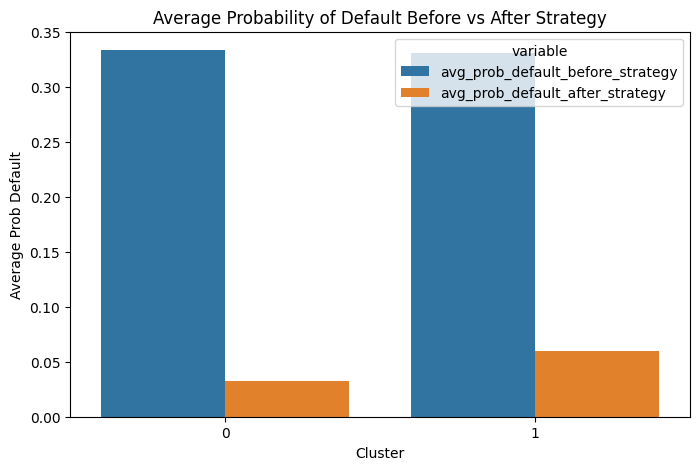

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=impact_summary.melt(id_vars='cluster', value_vars=['avg_prob_default_before_strategy', 'avg_prob_default_after_strategy']),
            x='cluster', y='value', hue='variable')
plt.title('Average Probability of Default Before vs After Strategy')
plt.ylabel('Average Prob Default')
plt.xlabel('Cluster')
plt.show()


In [ ]:
import numpy as np

def simulate_reward(prob_default, cluster, chosen_arm, effects_prior):
    """
    Simulate a reward (success/failure) for a given customer and strategy arm.

    Parameters:
    -----------
    prob_default : float
        Predicted default probability from ML model.
    cluster : int
        Cluster ID of the customer.
    chosen_arm : str
        Selected strategy arm for this iteration.
    effects_prior : dict
        Bayesian prior (alpha, beta) for each arm per cluster.

    Returns:
    --------
    reward : int
        1 if customer pays successfully (success), 0 if default.
    sampled_effect : float
        Effect of chosen arm sampled from Bayesian prior.
    """
    # Sample effect from Bayesian prior (Beta distribution)
    sampled_effect = np.random.beta(
        effects_prior[cluster][chosen_arm]['alpha'],
        effects_prior[cluster][chosen_arm]['beta']
    )


    p_success = max(min(1 - prob_default + sampled_effect, 1), 0)

    # Simulate reward as Bernoulli trial
    reward = np.random.binomial(1, p_success)

    return reward, sampled_effect


In [ ]:

# This function probabilistically simulates customer outcomes (success or default) after applying a prescriptive strategy arm.
# It combines the ML-predicted default probability with a sampled effect from the Bayesian prior of the strategy.
# The output is a simulated reward (1 = success, 0 = default) and the sampled effect for each iteration.
# Running Monte Carlo simulations for all customers produces an average probability of default after strategy.
# In this case, the simulation shows that the recommended strategies reduce average default risk by 82.1% for cluster 0 and 73.7% for cluster 1, reflecting a realistic probabilistic impact of the interventions.

In [ ]:

data_sim = data_ts.copy()

best_arms = best_arm_per_cluster
np.random.seed(42)

n_simulations = 1000  # n Monte Carlo simulation
simulated_probs = []

for idx, row in data_sim.iterrows():
    cluster = row['cluster']
    prob_default = row['prob_default']
    chosen_arm = best_arms[cluster]

    rewards = []
    for _ in range(n_simulations):
        reward, sampled_effect = simulate_reward(prob_default, cluster, chosen_arm, effects_prior)
        prob_after = max(min(prob_default - sampled_effect, 1), 0)
        rewards.append(prob_after)

    data_sim.loc[idx, 'prob_default_after_strategy'] = np.mean(rewards)

impact_summary = data_sim.groupby('cluster')[['prob_default', 'prob_default_after_strategy']].mean().reset_index()
impact_summary.rename(columns={
    'prob_default': 'avg_prob_default_before_strategy',
    'prob_default_after_strategy': 'avg_prob_default_after_strategy'
}, inplace=True)

impact_summary['reduction_pct'] = (impact_summary['avg_prob_default_before_strategy'] -
                                   impact_summary['avg_prob_default_after_strategy']) / impact_summary['avg_prob_default_before_strategy'] * 100

print(impact_summary)


   cluster  avg_prob_default_before_strategy  avg_prob_default_after_strategy  \
0        0                          0.333516                         0.059689   
1        1                          0.330585                         0.086997   

   reduction_pct  
0      82.103221  
1      73.683984  


In [ ]:
# The histogram/KDE visualizes the distribution of customer default probabilities after applying the recommended strategy per cluster.
# The blue curve represents the simulated probabilities after strategy, generated via Monte Carlo sampling of the Bayesian prior effects.
# The red dashed line shows the average predicted default probability before strategy.
# A leftward shift of the blue curve relative to the red line indicates the strategy effectively reduces default risk, while the curve width reflects uncertainty and variability in the outcome.

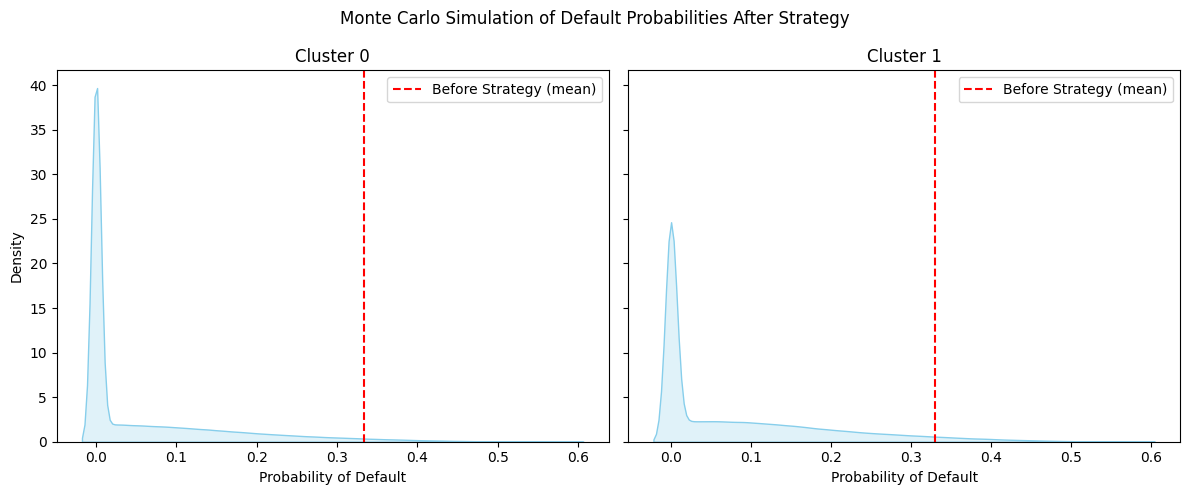

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


clusters = data_sim['cluster'].unique()
n_simulations = 1000
np.random.seed(42)

fig, axes = plt.subplots(1, len(clusters), figsize=(12, 5), sharey=True)

for i, cluster in enumerate(clusters):
    cluster_data = data_sim[data_sim['cluster'] == cluster]
    all_sim_probs = []

    for idx, row in cluster_data.iterrows():
        chosen_arm = best_arm_per_cluster[cluster]
        prob_default = row['prob_default']

        sim_probs = []
        for _ in range(n_simulations):
            _, sampled_effect = simulate_reward(prob_default, cluster, chosen_arm, effects_prior)
            prob_after = max(min(prob_default - sampled_effect, 1), 0)
            sim_probs.append(prob_after)
        all_sim_probs.extend(sim_probs)

    sns.kdeplot(all_sim_probs, ax=axes[i], fill=True, color='skyblue')
    axes[i].axvline(cluster_data['prob_default'].mean(), color='red', linestyle='--', label='Before Strategy (mean)')
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_xlabel('Probability of Default')
    axes[i].legend()

plt.suptitle('Monte Carlo Simulation of Default Probabilities After Strategy')
plt.tight_layout()
plt.show()
